In [1]:
import qutip as qt
import matplotlib.pyplot as plt
from pycqed import *
from pycqed.util import *

## Local Basis Reduction Example

Reduction techniques are important to simplify the analysis of quantum annealing and computing systems. In general one wants to map the two lowest energy levels of the circuit Hamiltonian to a two-level system described by Pauli operators. Here we use [G. Consani's local basis reduction technique](https://arxiv.org/abs/1912.00464) which is superior to other methods with a wider range of validity and applicability.

### RF-SQUID Qubit

We will use the traditional RF-SQUID qubit as an example, which is setup as in the `csfq-example.ipynb` notebook:

Using existing PyCQED tmp output root directory '/tmp/.pycqed/'.


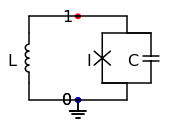

In [2]:
circuit = CircuitSpec("RF-SQUID Qubit Circuit")
circuit.addBranch(["L"],"up",0,False,arm_len=0.5)
circuit.addBranch(["I","C"],"down",1,True,arm_len=0.5)
circuit.drawCircuit(inline=True)

# Create Hamiltonian generator
hamil = HamilSpec(circuit,mode="node")
hamil.setTruncation(1,20,"charge")
hamil.prepareOperators()

# Fabrication parameters
Ca = 60.0 # fF/um^2
Jc = 3.0  # uA/um^2
Aj = 0.2*1.2#0.4**2 # um^2

# Set the parameter values
hamil.setParameterValues(
    'C',Ca*Aj,
    'I',Jc*Aj,
    'L',570.0,
    'phi10e',0.5
)

To use the local basis method we need to solve the eigenvalues and vectors at parameter value that we require the Pauli coefficients:

In [3]:
# Configure the diagonaliser
hamil.setDiagConfig(get_vectors=True)

The eigenvalues are used to generate the reduced Hamiltonian in the energy eigenbasis, and the eigenvectors are used to get the expectation value of the operator that defines the computational basis. With flux qubits a natural choice is the persistent current operator, which describes the average amplitude of the circulating currents in the loop. Therefore we need to get the branch current operators during a sweep, which in general will depend on certain parameters:

In [4]:
spec = [
    hamil.sweepSpec('phi10e',0.49,0.51,101)
]
evals = [
    hamil.evalSpec('getHamiltonian',True,None),
    hamil.evalSpec('getBranchCurrents',False,None),
]
sweep = hamil.paramSweep(spec,eval_spec=evals,timesweep=True)

Parameter Sweep Duration:
  Initialization:	0.057 s
  Loop duration:	1.098 s
  Avg iteration:	0.011 s


Get the Hamiltonian eigenvalues and vectors first:

In [5]:
x,EV,v = hamil.getSweep(sweep,'phi10e',{},evaluable='getHamiltonian')
E = EV[:,0]
V = EV[:,1]

Text(0, 0.5, '$E_{g,i}$ (GHz)')

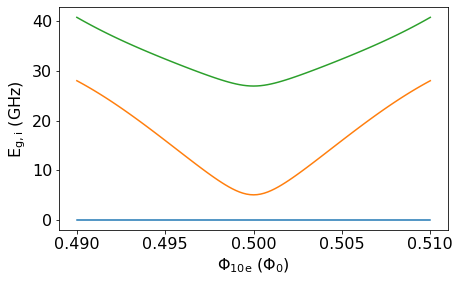

In [6]:
for i in range(3):
    plt.plot(x,E[i]-E[0])
plt.xlabel("$\\Phi_{10e}$ ($\\Phi_0$)")
plt.ylabel("$E_{g,i}$ (GHz)")

Now get the branch current operators:

In [7]:
x,Iops,v = hamil.getSweep(sweep,'phi10e',{},evaluable='getBranchCurrents')

We can check the persistent current expectation values in the ground state by projecting on the energy eigenstates. We can use either branch operator, one corresponding to the inductive branch `(0,1)` and the other corresponding to the JJ branch `(1,0)`:

In [8]:
Iexp1 = np.array([0.0]*len(x))
Iexp2 = np.array([0.0]*len(x))
for i in range(len(x)):
    Iexp1[i] = (V[0,i].dag()*Iops[i][(0,1)]*V[0,i])[0][0][0].real
    Iexp2[i] = (V[0,i].dag()*Iops[i][(1,0)]*V[0,i])[0][0][0].real

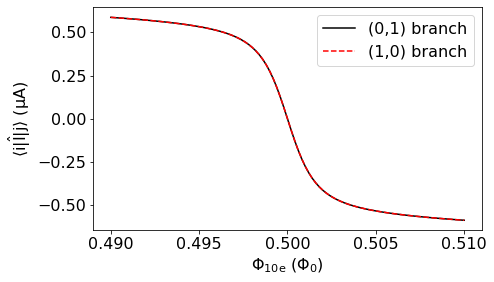

In [10]:
plt.plot(x,Iexp1,"k-",label="(0,1) branch")
plt.plot(x,Iexp2,"r--",label="(1,0) branch")
plt.xlabel("$\\Phi_{10e}$ ($\\Phi_0$)")
plt.ylabel("$\\langle i| \hat{I} |j \\rangle$ ($\mu A$)")
plt.legend()

Because of our choice of basis here (charge), the flux operator is independent of `phi10e`, and thus there is no need to generate the operator at each value of flux bias. The Josephson current operator however does depend on `phi10e` so if it were used one would have to regenerate it for each flux bias value. In most cases it should suffice to get a branch current operator that is unique to a particular loop and is independent of the parameters being swept:

In [10]:
Op = hamil.getBranchCurrentOperator((0,1))
Iexp = np.array([0.0]*len(x))
for i in range(len(x)):
    Iexp[i] = (V[0,i].dag()*Op*V[0,i])[0][0][0].real

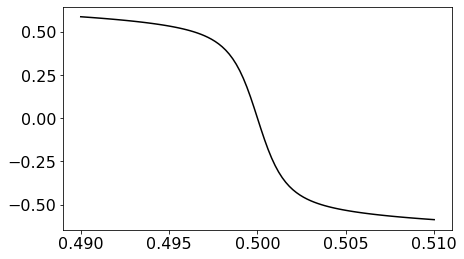

In [11]:
plt.plot(x,Iexp,"k-")
plt.xlabel("$\\Phi_{10e}$ ($\\Phi_0$)")
plt.ylabel("$\\langle i| \hat{I} |j \\rangle$ ($\mu A$)")

Now we are ready to get the Pauli coefficients for this circuit model:

In [12]:
hx,hy,hz = pauliCoefficients(E, V, Op)

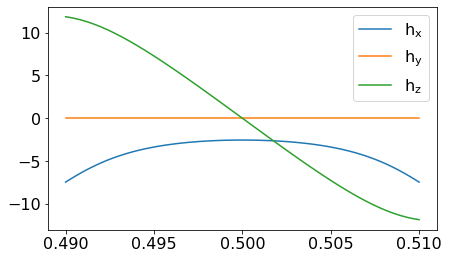

In [13]:
plt.plot(x,hx,label="$h_x$")
plt.plot(x,hy,label="$h_y$")
plt.plot(x,hz,label="$h_z$")
plt.legend()
plt.xlabel("$\\Phi_{10e}$ ($\\Phi_0$)")
plt.ylabel("Energy (GHz)")

We see that $h_y$ is zero and $h_x$ and $h_z$ behave as expected. We can verify the results by overlaying the energy spectrum generated by this two-level model to that of the original circuit:

In [14]:
# Check if spectrum matches original
Ered = np.array([0.0]*len(x))
for i in range(len(x)):
    H = hx[i]*qt.sigmax() + hy[i]*qt.sigmay() + hz[i]*qt.sigmaz()
    El = H.eigenenergies()
    Ered[i] = El[1]-El[0]

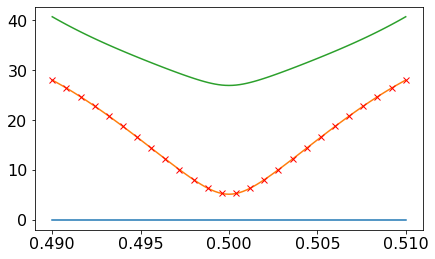

In [15]:
for i in range(3):
    plt.plot(x,E[i]-E[0])
plt.plot(x[::4],Ered[::4],"rx",label="Red.")
plt.xlabel("$\\Phi_{10e}$ ($\\Phi_0$)")
plt.ylabel("$E_{g,i}$ (GHz)")

Indeed the gap between the first two states matches almost exactly that of the original circuit:

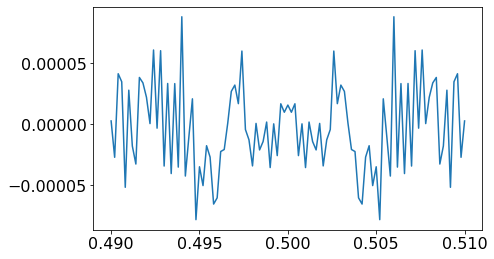

In [16]:
plt.plot(x,(E[1]-E[0])-Ered)
plt.xlabel("$\\Phi_{10e}$ ($\\Phi_0$)")
plt.ylabel("Relative Error")

### Cooper-Pair Box Qubit

Now we will perform the reduction on the cooper pair box, where now the computation basis is defined by the charge states.

Using existing PyCQED tmp output root directory '/tmp/.pycqed/'.


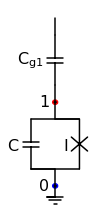

In [17]:
circuit = CircuitSpec("CPB")
circuit.addBranch(["C","I"],"up",0,False)
circuit.addChargeBias('up',1,lead_len=1)
circuit.drawCircuit(inline=True)

# Create Hamiltonian generator
hamil = HamilSpec(circuit,mode="node")
hamil.setTruncation(1,20,"charge")
hamil.prepareOperators()

# Fabrication parameters
Ca = 60.0 # fF/um^2
Jc = 1.0  # uA/um^2
Aj = 0.1*0.1#0.4**2 # um^2

# Set the parameter values
hamil.setParameterValues(
    'C',Ca*Aj,
    'I',Jc*Aj,
    'Cg1',1.0,
    'Q1e',0.5
)

# Configure the diagonaliser
hamil.setDiagConfig(get_vectors=True)

In [18]:
spec = [
    hamil.sweepSpec('Q1e',0.4,0.6,101)
#    hamil.sweepSpec('phi10e',-0.51,-0.49,101)
]
evals = [
    hamil.evalSpec('getHamiltonian',True,None),
    hamil.evalSpec('getNodeVoltages',False,None),
]
sweep = hamil.paramSweep(spec,eval_spec=evals,timesweep=True)

Parameter Sweep Duration:
  Initialization:	0.004 s
  Loop duration:	0.562 s
  Avg iteration:	0.006 s


In [19]:
x,EV,v = hamil.getSweep(sweep,'Q1e',{},evaluable='getHamiltonian')
E = EV[:,0]
V = EV[:,1]

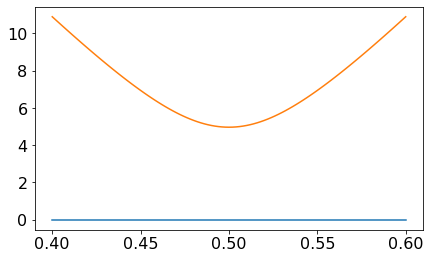

In [20]:
for i in range(2):
    plt.plot(x,E[i]-E[0])
plt.xlabel("$Q_{1e}$ ($2e$)")
plt.ylabel("$E_{g,i}$ (GHz)")

Now get the node voltage operators:

In [21]:
x,Vops,v = hamil.getSweep(sweep,'Q1e',{},evaluable='getNodeVoltages')

In this case a unique operator must be used for each gate charge setpoint as underlying charge operator is shifted by the induced charge:

In [22]:
Vexp = np.array([0.0]*len(x))
for i in range(len(x)):
    Vexp[i] = (V[0,i].dag()*Vops[i][1]*V[0,i])[0][0][0].real

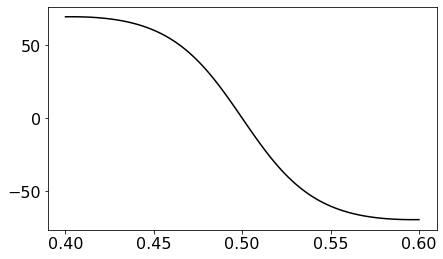

In [23]:
plt.plot(x,Vexp,"k-")
plt.xlabel("$Q_{1e}$ ($2e$)")
plt.ylabel("$E_{g,i}$ (GHz)")

In [24]:
hx,hy,hz = pauliCoefficients(E, V, [Vops[i][1] for i in range(len(x))])

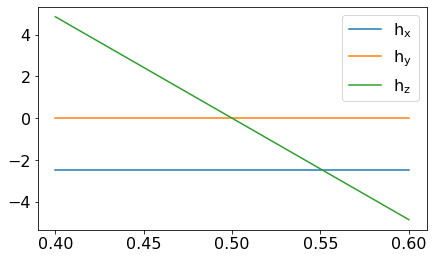

In [25]:
plt.plot(x,hx,label="$h_x$")
plt.plot(x,hy,label="$h_y$")
plt.plot(x,hz,label="$h_z$")
plt.legend()
plt.xlabel("$Q_{1e}$ ($2e$)")
plt.ylabel("Energy (GHz)")

In [26]:
# Check if spectrum matches original
Ered = np.array([0.0]*len(x))
for i in range(len(x)):
    H = hx[i]*qt.sigmax() + hy[i]*qt.sigmay() + hz[i]*qt.sigmaz()
    El = H.eigenenergies()
    Ered[i] = El[1]-El[0]

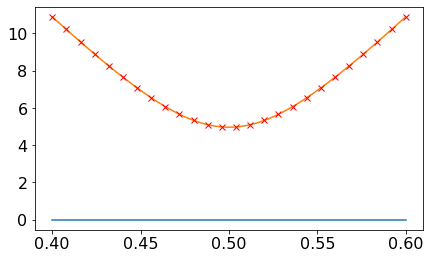

In [27]:
for i in range(2):
    plt.plot(x,E[i]-E[0])
plt.plot(x[::4],Ered[::4],"rx",label="Red.")
plt.xlabel("$Q_{1e}$ ($2e$)")
plt.ylabel("$E_{g,i}$ (GHz)")

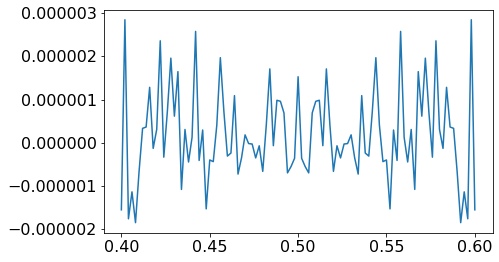

In [28]:
plt.plot(x,(E[1]-E[0])-Ered)
plt.xlabel("$Q_{1e}$ ($2e$)")
plt.ylabel("Relative Error")